In [1]:
!pip install --quiet BackTranslation

     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 1.4 MB 60.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 


In [2]:
!pip install --quiet sentence-transformers

     |████████████████████████████████| 85 kB 4.3 MB/s 
     |████████████████████████████████| 4.7 MB 58.2 MB/s 
     |████████████████████████████████| 1.3 MB 57.8 MB/s 
     |████████████████████████████████| 120 kB 67.7 MB/s 
     |████████████████████████████████| 6.6 MB 62.9 MB/s 


In [24]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [25]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [26]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [27]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [28]:
data = data.dropna()

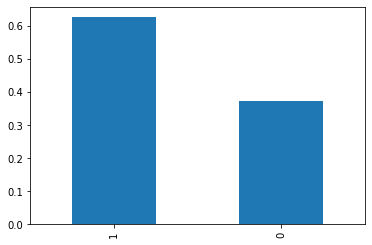

In [29]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [30]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [31]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [32]:
len(train_data)*0.25, type(train_labels), train_labels.shape


(802.0, numpy.ndarray, (3208,))

In [33]:
train_data = train_data.iloc[0:802]
train_labels = train_labels[0:802]

In [34]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 802, 802)

In [35]:
from BackTranslation import BackTranslation
trans = BackTranslation(url=[
      'translate.google.com',
      'translate.google.co.kr',
    ], proxies={'http': '127.0.0.1:1234', 'http://host.name': '127.0.0.1:4012'})
result = trans.translate('What is new in python programming?', src='en', tmp = 'zh-cn')
print(result.result_text)

What are the new features in Python programming?


In [36]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      try:
        result = trans.translate(sentence2[idxA], src='en', tmp = 'zh-cn')
        #sAns = random_deletion(sentence2[idxA])
        #print(sAns)
        sAns = result.result_text
        pairs.append(InputExample(texts=[dAns, sAns], label=label))
        i = i+1
        print(i,end="-")
      except:
        break
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [37]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [38]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [39]:
len(test_examples)

802

In [40]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-256-257-258-259-260-261-262-263-264-265-No.of augmented examples :  265


In [41]:
len(train_examples)

821

In [42]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/BT25_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [43]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [44]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

52


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Training done...



                     ********** stsb-distilbert-base **********


0.8969720443565269

In [45]:
accf1 = pd.read_csv("/content/binary_sim_output/stsb-distilbert-base/binary_classification_evaluation_results.csv")

In [47]:
accf1[['cossim_accuracy', 'cossim_f1' ]].head()

,cossim_accuracy,cossim_f1
0,0.770574,0.832117


In [48]:
pearsonspearman = pd.read_csv("/content/binary_sim_output/stsb-distilbert-base/similarity_evaluation_SPRAG-test_results.csv")

In [50]:
pearsonspearman[['cosine_pearson', 'cosine_spearman']].head()

,cosine_pearson,cosine_spearman
0,0.573677,0.561451


In [51]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

52


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Training done...



                     ********** sentence-transformers/paraphrase-albert-small-v2 **********


0.8885190904897939

In [56]:
accf1 = pd.read_csv('/content/binary_sim_output/sentence-transformers/paraphrase-albert-small-v2/binary_classification_evaluation_results.csv')

In [57]:
accf1[['cossim_accuracy', 'cossim_f1' ]].head()

,cossim_accuracy,cossim_f1
0,0.760599,0.819277


In [54]:
pearsonspearman = pd.read_csv('/content/binary_sim_output/sentence-transformers/paraphrase-albert-small-v2/similarity_evaluation_SPRAG-test_results.csv')

In [55]:
pearsonspearman[['cosine_pearson', 'cosine_spearman']].head()

,cosine_pearson,cosine_spearman
0,0.536474,0.536736


In [58]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/490 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

52


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Iteration:   0%|          | 0/52 [00:00<?, ?it/s]

Training done...



                     ********** sentence-transformers/quora-distilbert-base **********


0.9048411132351715

In [59]:
accf1 = pd.read_csv('/content/binary_sim_output/sentence-transformers/quora-distilbert-base/binary_classification_evaluation_results.csv')

In [60]:
accf1[['cossim_accuracy', 'cossim_f1' ]].head()

,cossim_accuracy,cossim_f1
0,0.781796,0.834206


In [61]:
pearsonspearman = pd.read_csv('/content/binary_sim_output/sentence-transformers/quora-distilbert-base/similarity_evaluation_SPRAG-test_results.csv')

In [62]:
pearsonspearman[['cosine_pearson', 'cosine_spearman']].head()

,cosine_pearson,cosine_spearman
0,0.596841,0.589106


In [63]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

(768,)

In [64]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.2469]])